# ML Final Project


### Shruti Kotha, Mia Tey, Jeni Pham, and Shruti Patel

In [111]:
#add imports
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

## Final Project Objective: 
We can use the features (age, breed, color, animal, sex upon outcome, outcome subtype,
name) to predict outcome (Foster, Adoption, Transfer, Euthanize)

### Part 1. Data Preperation for Modeling

For this part of the assignment we read in our data and will perform various data prep techniques like data cleaning and feature engineering to prepare our data for modeling.

In [112]:
data = pd.read_csv('animaloutcomes.csv', skipinitialspace = True)
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


#### Data cleaning

View the distribution of "Outcome Type". We want to ensure there is sufficient data for each "Outcome Type" and if there isn't we can drop columns as needed.

In [113]:
outcome_counts = data['Outcome Type'].value_counts()
print(outcome_counts)

Outcome Type
Adoption           73675
Transfer           44935
Return to Owner    24404
Euthanasia          9959
Died                1468
Rto-Adopt           1061
Disposal             758
Missing               84
Relocate              27
Stolen                 5
Name: count, dtype: int64


First, our label column will be "Outcome Type", since that is what we want to predict. 
If there are any records that lack an entry for "Outcome Type" we drop them.

In [114]:
print("Length before droping Outcome Type: ", len(data['Outcome Type']))
data = data.dropna(subset=['Outcome Type'])
print("Length after drop Outcome Type: ", len(data['Outcome Type']))

Length before droping Outcome Type:  156406
Length after drop Outcome Type:  156376


Second, we want to drop "Outcome Subtype". Since most rows have NaN in the "Outcome Subtype" column, it won't be an important column for us to use in our model.

In [115]:
data.drop(columns=['Outcome Subtype', 'Name', 'DateTime', 'Date of Birth', 'Animal ID'], inplace=True)
data.head()

,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,May 2019,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,Aug 2020,Euthanasia,Other,Unknown,1 year,Raccoon,Gray
3,Feb 2016,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,Mar 2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


It looks like there are no missing values for 'Outcome Type' anymore... Great!

TODO: delete this

Looking at the names column, there are a lot of blank entries for names. For the purposes of testing, we are
going to test with both dropping the names column and keeping it. 
First, let's see how many blank entries there are.
Second, create a temporary dataset that drops records with N/A for name. Later, we will see if accuracy is better or worse with the version that drops null name entries.

In [116]:
# total_null =  data["Name"].isnull().sum()
# print("Total missing values in 'Name' col before drop: ", total_null)
# print("Ratio of total records with N/A for 'Name': ", total_null/len(data["Name"]), "\n")

# # Create a temporary dataset that drops records with N/A for name
# temp_drop_data = data.dropna(subset=['Name'])
# # Verify we dropped the null records
# total_null =  temp_drop_data["Name"].isnull().sum()
# print("Total missing values in 'Name' col after drop: ", total_null)

As for the colors, since we plan on using them for our models later, we should simplify the categories, as there are way too many unique categories for testing.
First, there are entries such as 'black/white' and 'white/black' let's combine these into one label.
Second, there are a lot of unique combinations of two colors. For these records whose combination of color makes up <5% of all colors, add these into one column called 'Multicolor' and jointly categorize it with the 'Tricolor' attribute.

In [117]:
# Combine categories such as 'black/white' and 'white/black'
def join_same_color(color):
    color_components = color.split('/')
    color_components.sort()
    return '/'.join(color_components)
data['Color'] = data['Color'].apply(join_same_color)


# Create Multicolor category 
color_counts = data['Color'].value_counts()
color_percent = color_counts / color_counts.sum() * 100
less_than_5_percent = color_percent[color_percent < 1].index
data['Color'] = data['Color'].apply(lambda x: 'Multicolor' if x in less_than_5_percent or x == 'Tricolor' else x)

Create new column for seasons

In [118]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
    
data['Month'] = pd.to_datetime(data['MonthYear'], format='%b %Y').dt.month
data['Season'] = data['Month'].apply(get_season)
data = data.drop('Month', axis=1)
data.head()

,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Season
0,May 2019,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,Spring
1,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,Brown/White,Summer
2,Aug 2020,Euthanasia,Other,Unknown,1 year,Raccoon,Multicolor,Summer
3,Feb 2016,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Multicolor,Winter
4,Mar 2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Spring


We'll be categorizing the various breeds in the dataset. https://www.trainpetdog.com/dog-breed-size-chart/

In [119]:

# only keep records that are Dogs
records_to_keep = ['Dog']
dog_data = data[data['Animal Type'].isin(records_to_keep)]

# only keep top 100 most frequent dog breeds in dataset
top_100_breeds = dog_data['Breed'].value_counts().head(100).index
breeds_data = dog_data[dog_data['Breed'].isin(top_100_breeds)]
breeds_data = breeds_data.copy()

# print(top_100_breeds)



# large 70 + lbs avg, small, medium
breed_to_category = {
    'Pit Bull Mix': 'Medium/Large Breeds',
    'Labrador Retriever Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair Mix': 'Small Breeds',
    'German Shepherd Mix': 'Medium/Large Breeds',
    'Pit Bull': 'Medium/Large Breeds',
    'Australian Cattle Dog Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever': 'Medium/Large Breeds',
    'German Shepherd': 'Medium/Large Breeds',
    'Dachshund Mix': 'Medium/Small Breeds', 
    'Boxer Mix': 'Medium/Large Breeds',
    'Border Collie Mix': 'Medium/Large Breeds',
    'Miniature Poodle Mix': 'Small Breeds',
    'Siberian Husky Mix': 'Medium Breeds',
    'Australian Shepherd Mix': 'Medium/Large Breeds',
    'Catahoula Mix': 'Medium/Large Breeds',
    'Staffordshire Mix': 'Medium/Large Breeds',
    'Siberian Husky': 'Medium Breeds',
    'Rat Terrier Mix': 'Small Breeds',
    'Great Pyrenees Mix': 'Large Breeds',
    'Yorkshire Terrier Mix': 'Small Breeds',
    'Beagle Mix': 'Medium/Large Breeds',
    'Miniature Schnauzer Mix': 'Medium/Small Breeds',
    'Jack Russell Terrier Mix': 'Medium/Small Breeds',
    'Pointer Mix': 'Large Breeds',
    'Cairn Terrier Mix' : 'Small Breeds',
    'American Bulldog Mix': 'Medium/Large Breeds',                      
    'Chihuahua Longhair Mix': 'Small Breeds',   
    'Anatol Shepherd Mix': 'Medium/Large Breeds',
    'Rottweiler Mix': 'Medium/Large Breeds',
    'Australian Cattle Dog': 'Medium Breeds',
    'Black Mouth Cur Mix': 'Medium/Large Breeds',
    'Plott Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Pit Bull': 'Medium/Large Breeds',
    'Australian Kelpie Mix': 'Medium Breeds',
    'Shih Tzu Mix': 'Small Breeds',
    'Chihuahua Shorthair/Dachshund': 'Small Breeds',
    'Great Pyrenees': 'Large Breeds',
    'American Pit Bull Terrier Mix': 'Medium/Large Breeds',
    'German Shepherd/Labrador Retriever': 'Large Breeds',
    'Dachshund/Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever/German Shepherd': 'Large Breeds',
    'American Staffordshire Terrier Mix': 'Medium/Large Breeds',
    'Rottweiler': 'Large Breeds',
    'Boxer': 'Medium/Large Breeds',
    'Shih Tzu': 'Small Breeds',
    'Pit Bull/Labrador Retriever': 'Medium/Large Breeds',
    'Dachshund': 'Small Breeds',
    'Golden Retriever Mix': 'Large Breeds',
    'Maltese Mix': 'Small Breeds',
    'Border Terrier Mix': 'Small Breeds',
    'Miniature Pinscher Mix': 'Small Breeds',
    'Yorkshire Terrier': 'Small Breeds',
    'Blue Lacy Mix': 'Medium/Large Breeds',
    'Doberman Pinsch Mix': 'Medium/Large Breeds',
    'Miniature Poodle': 'Small Breeds',
    'Chow Chow Mix': 'Medium/Large Breeds',
    'American Pit Bull Terrier': 'Medium/Large Breeds',
    'Cairn Terrier': 'Small Breeds',
    'Border Collie': 'Medium/Large Breeds',
    'Queensland Heeler Mix': 'Medium Breeds',
    'Doberman Pinsch': 'Medium/Large Breeds',
    'Basset Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Border Collie': 'Large Breeds',
    'Alaskan Husky Mix': 'Medium/Large Breeds',
    'Pug Mix': 'Small Breeds',
    'Beagle': 'Small Breeds',
    'Pomeranian Mix': 'Small Breeds',
    'Mastiff Mix': 'Large Breeds',
    'Cocker Spaniel Mix': 'Small Breeds',
    'Cardigan Welsh Corgi Mix': 'Medium Breeds',
    'Miniature Schnauzer': 'Small Breeds',
    'Lhasa Apso Mix': 'Small Breeds',
    'Chinese Sharpei Mix': 'Medium/Large Breeds',
    'Australian Shepherd': 'Medium/Large Breeds',
    'Labrador Retriever/Australian Cattle Dog': 'Medium/Large Breeds',
    'Black/Tan Hound Mix': 'Medium/Large Breeds',
    'Pug': 'Small Breeds',
    'Chihuahua Longhair': 'Small Breeds',
    'Great Dane Mix': 'Large Breeds',
    'Boston Terrier Mix': 'Small Breeds',
    'Border Collie/Labrador Retriever': 'Large Breeds',
    'Labrador Retriever/Great Pyrenees' : 'Large Breeds',
    'Dachshund Wirehair Mix' : 'Small Breeds',
    'Dachshund Longhair Mix' : 'Small Breeds',
    'Alaskan Husky' : 'Medium/Large Breeds',
    'Flat Coat Retriever Mix' : 'Large Breeds',
    'Manchester Terrier Mix' : 'Small Breeds',
    'Toy Poodle Mix' : 'Small Breeds',
    'American Bulldog' : 'Medium/Large Breeds',
    'Rat Terrier' : 'Small Breeds',
    'Collie Smooth Mix' : 'Medium/Large Breeds',
    'Maltese' : 'Small Breeds',
    'Anatol Shepherd' : 'Medium/Large Breeds',
    'Staffordshire' : 'Medium/Large Breeds',
    'Belgian Malinois Mix' : 'Medium/Large Breeds',
    'Pit Bull/Boxer' : 'Medium/Large Breeds',
    'Norfolk Terrier Mix' : 'Small Breeds',
    'Australian Cattle Dog/Labrador Retriever' : 'Medium/Large Breeds',
    'Rhod Ridgeback Mix' : 'Large Breeds'         
}
print()
print("Distribution based on size of breed:")

categories = [breed_to_category.get(breed) for breed in breeds_data['Breed']]

category_counts = Counter(categories)

for category, count in category_counts.items():
    print(f'{category}: {count}')

# to do add a size category with the breed to wsize mapping
breeds_data.loc[:, 'Size'] = breeds_data['Breed'].map(breed_to_category)
dog_data = breeds_data
# dog_data["Breed"] = dog_data["Size"]

# print(len(dog_data))



Distribution based on size of breed:
Small Breeds: 17145
Medium/Large Breeds: 41783
Large Breeds: 3911
Medium Breeds: 2854
Medium/Small Breeds: 2448


In [120]:
dog_data.head()

,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Season,Size
1,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,Brown/White,Summer,Small Breeds
5,Oct 2020,Adoption,Dog,Spayed Female,7 years,Chihuahua Shorthair Mix,Brown,Fall,Small Breeds
13,Jun 2020,Return to Owner,Dog,Intact Female,2 years,Pit Bull,Blue/White,Summer,Medium/Large Breeds
14,Oct 2021,Transfer,Dog,Intact Female,2 years,Chihuahua Shorthair Mix,Black/White,Fall,Small Breeds
27,Jun 2018,Adoption,Dog,Neutered Male,9 years,Chihuahua Shorthair Mix,Multicolor,Summer,Small Breeds


#### Graphing Data Distributions

We will be graphing data distributions as part of data exploration. We will be looking for any imbalances, outliers, or anything that could potentially skeww the results of our data. We will then correct that before modeling.

Plot distribution of colors:

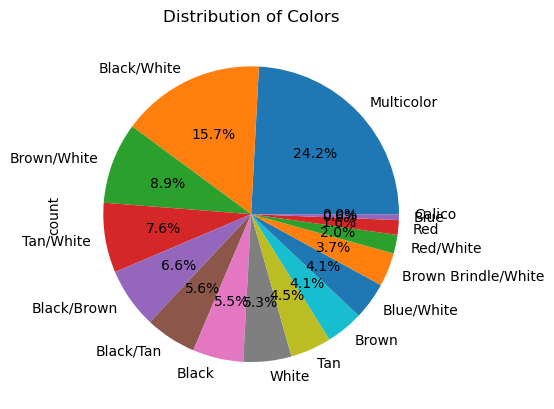

In [121]:
color_counts = dog_data['Color'].value_counts()
color_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Colors')
plt.show()

Display of distribution of season and outcome

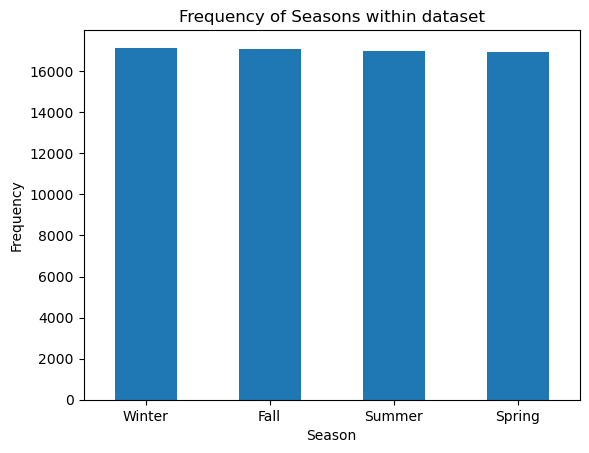

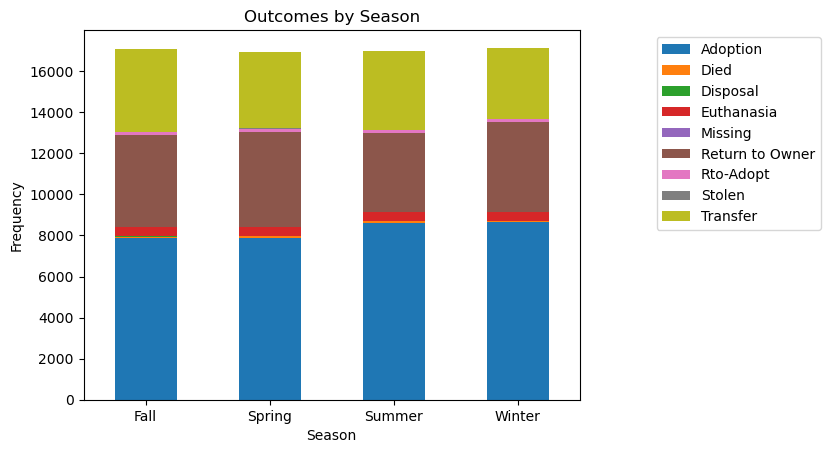

In [122]:
season_counts = dog_data['Season'].value_counts()
season_counts.plot(kind='bar')
plt.title('Frequency of Seasons within dataset')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.show()

outcome_by_season = pd.crosstab(dog_data['Season'], dog_data['Outcome Type'])
outcome_by_season.plot(kind='bar', stacked=True)
plt.title('Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.show()


Distribution of dog breed sizes for the top 100 breeds in the dataset.  

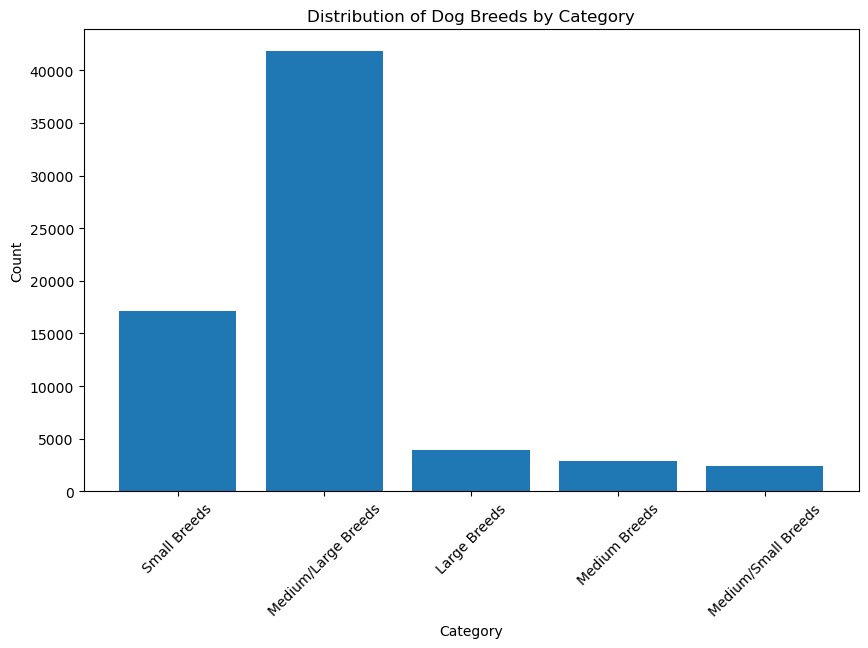

In [123]:
category_labels = [label for label, value in category_counts.items() if label is not None]
category_values = [value for label, value in category_counts.items() if label is not None]


plt.figure(figsize=(10, 6))
plt.bar(category_labels, category_values)
plt.title('Distribution of Dog Breeds by Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.xticks(rotation=45)

plt.show()

Distribution of dog sex upon Outcome.

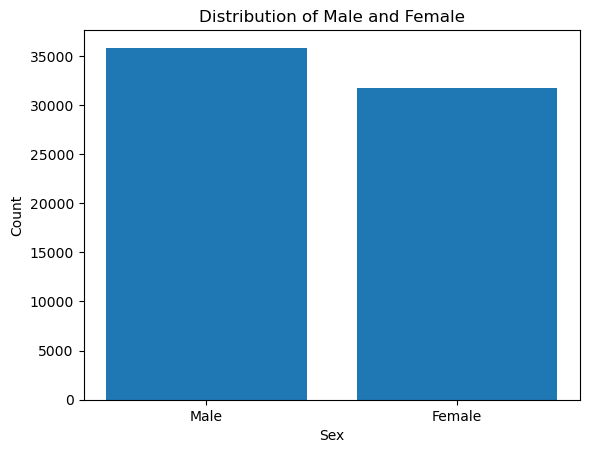

Number of Males: 35836
Number of Females: 31739


In [124]:
sex_upon_outcome = dog_data["Sex upon Outcome"]

male = 0
female = 0

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Male" in outcome:
            male += 1
        elif "Female" in outcome:
            female += 1

        
categories = ["Male", "Female"]
counts = [male, female]

plt.bar(categories, counts)
plt.title("Distribution of Male and Female")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

print(f"Number of Males: {male}")
print(f"Number of Females: {female}")



Distrubtion of nuetured vs spayed at outcome.

Sex upon Outcome
Neutered Male    27445
Spayed Female    24152
Intact Male       8391
Intact Female     7587
Unknown            565
Name: count, dtype: int64


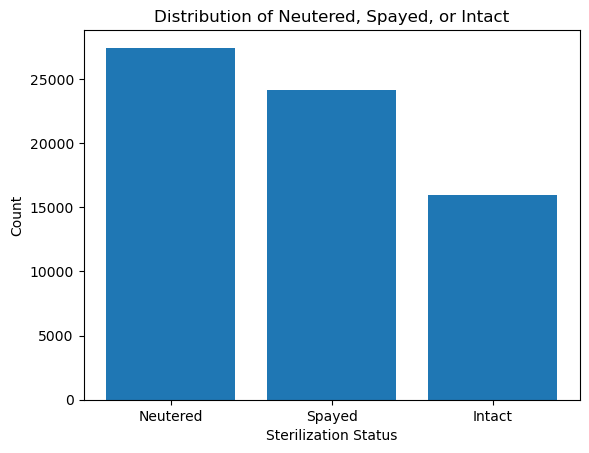

Number of Neutered: 27445
Number of Spayed: 24152
Number of Intact: 15978


In [125]:
neutered = 0
spayed = 0
intact = 0

sex_counts = dog_data["Sex upon Outcome"].value_counts()
print(sex_counts)

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Neutered" in outcome:
            neutered += 1
        elif "Spayed" in outcome:
            spayed += 1
        elif "Intact" in outcome: 
            intact += 1
        
categories = ["Neutered", "Spayed", "Intact"]
counts = [neutered, spayed, intact]

plt.bar(categories, counts)
plt.title("Distribution of Neutered, Spayed, or Intact")
plt.xlabel("Sterilization Status")
plt.ylabel("Count")
plt.show()

print(f"Number of Neutered: {neutered}")
print(f"Number of Spayed: {spayed}")
print(f"Number of Intact: {intact}")


Distribution of Months when animals were registered (?)

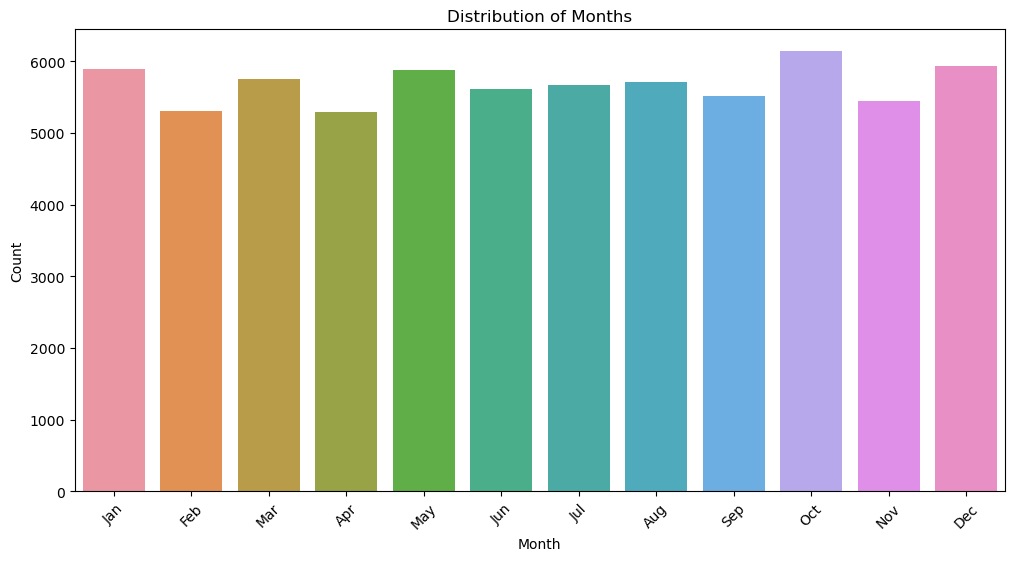

In [126]:
month_data = dog_data['MonthYear']
df = pd.DataFrame(month_data)
pattern = r'([a-zA-Z]{3}) \d{4}'
df['MonthYear'] = df['MonthYear'].str.extract(pattern)
# print(df)
data.head()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month_counts = df['MonthYear'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, order=month_order)
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



Convert the age upon outcome into months and then plot the distribution.

Mean Age (in months): 30.50
Median Age (in months): 12.00
Mode Age (in months): 24


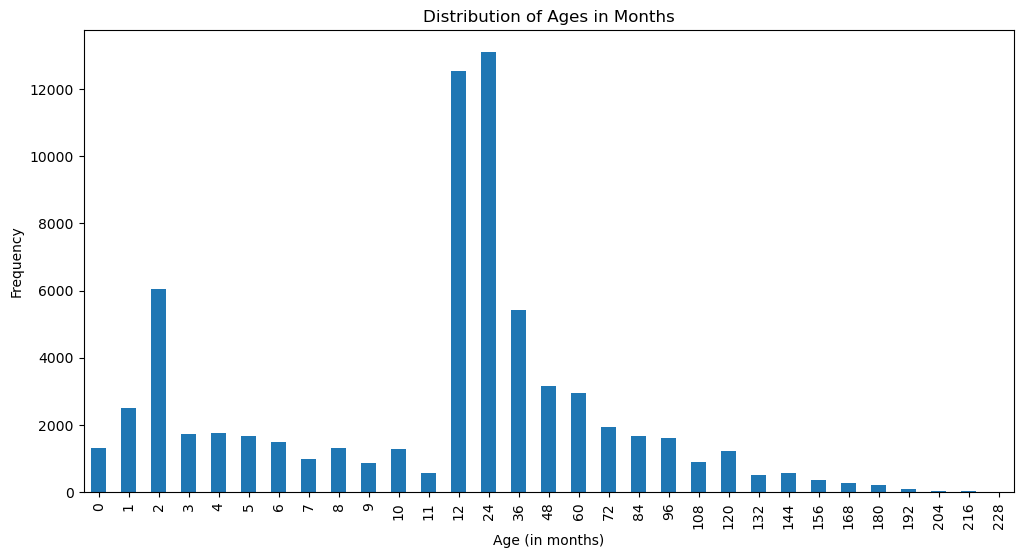

In [127]:
def convert_to_months(age_str):
    # Split the age string into value and unit
    value, unit = age_str.split()
    value = int(value)
    
    if 'year' in unit or 'years' in unit:
        return value * 12
    elif 'month' in unit or 'months' in unit:
        return value
    elif 'week' in unit or 'weeks' in unit:
        return value // 4  # Approximate conversion: 1 month = 4 weeks
    elif 'day' in unit or 'days' in unit:
        return value // 30 # Approximate conversion: 1 month = 30 days
    else:
        return 0  # default case

age_data = dog_data['Age upon Outcome']
df = pd.DataFrame(age_data)
df['Age upon Outcome'] = df['Age upon Outcome'].fillna('0 days')  #  fills NaN with '0 days'
# Apply the conversion function to the column
df['Age upon Outcome'] = df['Age upon Outcome'].apply(convert_to_months)
# print(df.head())

mean_age = df['Age upon Outcome'].mean()
median_age = df['Age upon Outcome'].median()
mode_age = df['Age upon Outcome'].mode()
age_df = df

print(f"Mean Age (in months): {mean_age:.2f}")
print(f"Median Age (in months): {median_age:.2f}")
print(f"Mode Age (in months): {mode_age.iloc[0]}")  

age_counts = df.loc[(df['Age upon Outcome'] >= 0) & (df['Age upon Outcome'] <= 228), 'Age upon Outcome'].value_counts().sort_index()
age_counts.plot(kind='bar', figsize=(12,6))
plt.title('Distribution of Ages in Months')
plt.xlabel('Age (in months)')
plt.ylabel('Frequency')
plt.show()





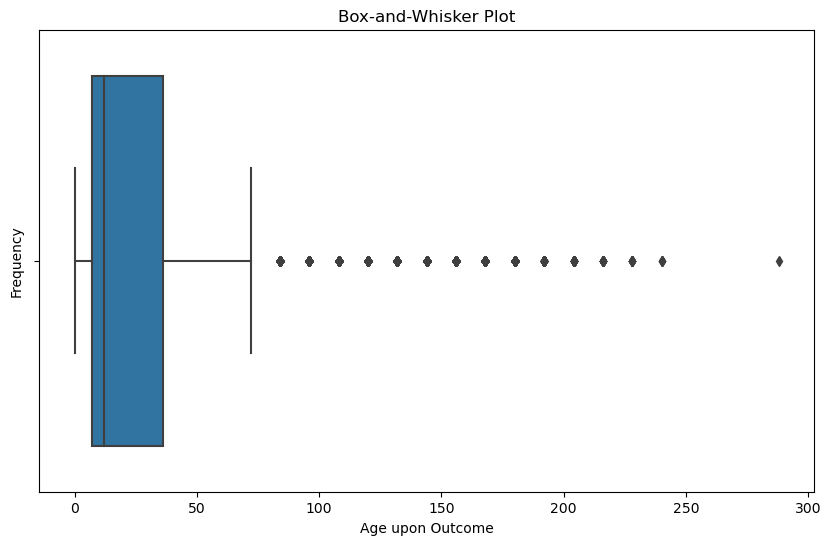

50% of dog's ages in the dataset are between: 7.0 and 36.0 months


In [128]:
# remove any negative ages
df = df[df['Age upon Outcome'] >= 0]

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Age upon Outcome'])
plt.xlabel('Age upon Outcome')
plt.ylabel('Frequency')
plt.title(f'Box-and-Whisker Plot')
plt.show()
q1 = df['Age upon Outcome'].quantile(0.25)
q3 = df['Age upon Outcome'].quantile(0.75)
iqr = q3 - q1
print(f"50% of dog's ages in the dataset are between: {q1} and {q3} months")


### Feature Engineering for Models

In [129]:
# drop the columns we don't need for our models
dog_data.drop(columns=['Animal Type', 'MonthYear', 'Breed'], inplace=True)
dog_data.head()

,Outcome Type,Sex upon Outcome,Age upon Outcome,Color,Season,Size
1,Adoption,Neutered Male,1 year,Brown/White,Summer,Small Breeds
5,Adoption,Spayed Female,7 years,Brown,Fall,Small Breeds
13,Return to Owner,Intact Female,2 years,Blue/White,Summer,Medium/Large Breeds
14,Transfer,Intact Female,2 years,Black/White,Fall,Small Breeds
27,Adoption,Neutered Male,9 years,Multicolor,Summer,Small Breeds


#### Age: Years to Months
Change age to be uniformly described by months. 

In [130]:
dog_data = dog_data.drop(columns=['Age upon Outcome'])
dog_data = pd.concat([dog_data, df.iloc[:, 0]], axis=1)
dog_data = dog_data[dog_data['Age upon Outcome'] >= 0]
dog_data.head()

,Outcome Type,Sex upon Outcome,Color,Season,Size,Age upon Outcome
1,Adoption,Neutered Male,Brown/White,Summer,Small Breeds,12.0
5,Adoption,Spayed Female,Brown,Fall,Small Breeds,84.0
13,Return to Owner,Intact Female,Blue/White,Summer,Medium/Large Breeds,24.0
14,Transfer,Intact Female,Black/White,Fall,Small Breeds,24.0
27,Adoption,Neutered Male,Multicolor,Summer,Small Breeds,108.0


#### Encode Sex: 
This code performs one-hot encoding on the categorical columns 'Sex upon Outcome' and 'Color' in the 'dog_data' DataFrame, creating binary columns for each category. The encoded columns are then concatenated with the original DataFrame, and the original categorical columns are dropped, resulting in a DataFrame with expanded feature representations for 'Sex upon Outcome' and 'Color'.

In [131]:
encoded_sex = pd.get_dummies(dog_data['Sex upon Outcome'], prefix='Sex upon Outcome').astype(int)
encoded_colors = pd.get_dummies(dog_data['Color'], prefix='Color').astype(int)
dog_data = pd.concat([dog_data, encoded_sex, encoded_colors], axis=1)
dog_data = dog_data.drop(columns=['Color', 'Sex upon Outcome'])
dog_data.head()



,Outcome Type,Season,Size,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,...,Color_Brown,Color_Brown Brindle/White,Color_Brown/White,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White
1,Adoption,Summer,Small Breeds,12.0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,Adoption,Fall,Small Breeds,84.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
13,Return to Owner,Summer,Medium/Large Breeds,24.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Transfer,Fall,Small Breeds,24.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,Adoption,Summer,Small Breeds,108.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Encode Size: 
This code snippet encodes the 'Size' column in the 'dog_data' DataFrame ordinally based on predefined size categories. It creates a new column named 'Breed size' where each dog's size is represented by an ordinal encoding, and subsequently, the original 'Size' column is dropped from the DataFrame. 

In [132]:
# encode breeds ordinally
sizes = ['Small Breeds', 'Medium/Small Breeds', 'Medium/Large Breeds', 'Large Breeds']

size_encode_mapping = {
    'Small Breeds': 1,
    'Medium/Small Breeds': 2,
    'Medium Breeds': 3,
    'Medium/Large Breeds': 4,
    'Large Breeds': 5
}

dog_data['Breed size'] = dog_data['Size'].map(size_encode_mapping)
dog_data = dog_data.drop(columns=['Size'])


dog_data.head()

,Outcome Type,Season,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,Color_Black/Brown,...,Color_Brown Brindle/White,Color_Brown/White,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White,Breed size
1,Adoption,Summer,12.0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5,Adoption,Fall,84.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,Return to Owner,Summer,24.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
14,Transfer,Fall,24.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27,Adoption,Summer,108.0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


#### Encode Season: 
This code snippet encodes the 'Season' column in the 'dog_data' DataFrame cyclically using sine and cosine functions. It creates two new columns, 'Season_cos' and 'Season_sin', which represent the cyclic encoding of seasons. The original 'Season' column and an intermediate numeric encoding column are then dropped from the DataFrame, resulting in a dataset where seasons are represented as cyclical features through trigonometric functions.

In [133]:
import numpy as np

## encode seasons cyclically with sine and cosine functions
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
dog_data['Season_numeric_encode'] = dog_data['Season'].map(season_mapping)
dog_data['Season_cos'] = np.cos(2 * np.pi * dog_data['Season_numeric_encode'] / 4)
dog_data['Season_sin'] = np.sin(2 * np.pi * dog_data['Season_numeric_encode'] / 4)
dog_data = dog_data.drop(columns=['Season', 'Season_numeric_encode'])
dog_data.head()

,Outcome Type,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,Color_Black/Brown,Color_Black/Tan,...,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White,Breed size,Season_cos,Season_sin
1,Adoption,12.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.000000e+00,1.224647e-16
5,Adoption,84.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
13,Return to Owner,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,-1.000000e+00,1.224647e-16
14,Transfer,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
27,Adoption,108.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-1.000000e+00,1.224647e-16


### Data Modeling
We decided to only use dogs for this dataset because having cat and other would complicate results and cause
our data to fall victim to the curse of dimensionality. Additionally, breed will likely play a large role in accuracy. In order to use breed, we will have to center our focus on dogs.

### Model 1. Naive Bayes
First, we are using Naive Bayes on our data. The data has already been cleaned and engineered, so all we have to do is set the label and features variables.

In [134]:
#only use these columns from the dataset
# col_names = ['Sex upon Outcome', 'Breed', 'Color', 'Season']
# NB_df = dog_data.loc[:, col_names]
#append age from df and then append outcome type last
# NB_df = pd.concat([NB_df, df.iloc[:, 0]], axis=1)
# NB_df = pd.concat([NB_df, dog_data[['Outcome Type']]], axis=1)

#set label col to Outcome Type
label = dog_data['Outcome Type']
label = label.values.ravel()
features= dog_data.drop(['Outcome Type'],axis=1)


#verify we have correct columns
# NB_df.head()
dog_data.head()

,Outcome Type,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,Color_Black/Brown,Color_Black/Tan,...,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White,Breed size,Season_cos,Season_sin
1,Adoption,12.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.000000e+00,1.224647e-16
5,Adoption,84.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
13,Return to Owner,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,-1.000000e+00,1.224647e-16
14,Transfer,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
27,Adoption,108.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-1.000000e+00,1.224647e-16


 Next, create a Multinomial Naive Bayes classifier (since it supports categorical target 
variables) and perform a 10-fold cross validation on the classifier. 
Print accuracy.

In [137]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# verify shape is correct for NB model
print(dog_data.shape)
print(label.shape)

# normalize and scale features
features = pd.DataFrame(features)
label = pd.DataFrame(label)
le = LabelEncoder()
features = features.apply(le.fit_transform)
label = label.apply(le.fit_transform)

scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# finally model data and check accuracy
mnb = MultinomialNB()
mnb_CV = cross_val_score(mnb, features, label, cv=10)
print('Accuracy: ', mnb_CV.mean())

warnings.resetwarnings()

(68134, 26)
(68134,)
Accuracy:  0.6026067630595026


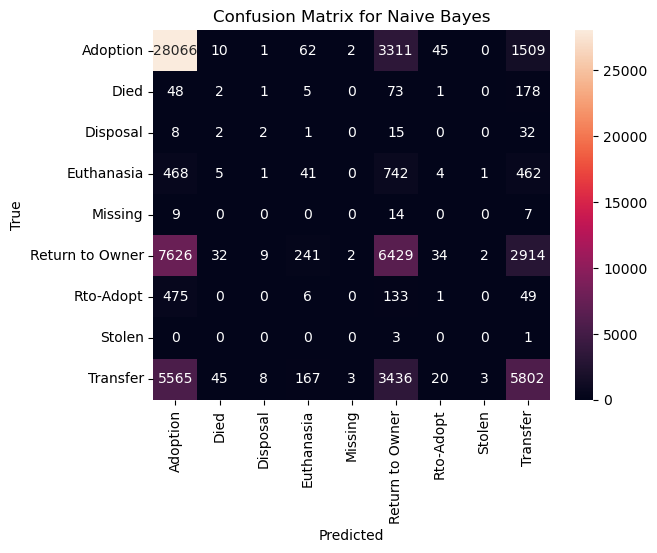

In [138]:
from sklearn.metrics import confusion_matrix

class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Model 2.5 Ensembling: (can move this later)
Let's try ensembling with random forests. Ensembling base classifiers usually performs better because it combines the predictions of multiple base classifiers.

#### Random forests: 
Let's use a GridSearchCV with a 3-fold CV and try 15, 25, and 50 base classifiers of fully grown decision trees and see which performs best. Then wrap the GridSearchCV in a cross_val_predict with 5-fold CV and display the classification report.

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
warnings.filterwarnings("ignore")

label = label.values.ravel()
rf = RandomForestClassifier()

parameter = {
    'n_estimators': [15, 25, 50]
}
grid = GridSearchCV(rf, parameter, cv=3)
pred = cross_val_predict(grid, features, label, cv=5)
# CV_score = cross_val_score(grid, features, label, cv=5)
# print('Accuracy: ', CV_score.mean())
print('Classification Report: \n', classification_report(label, pred))
warnings.resetwarnings()

Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.85      0.75     33006
           1       0.02      0.01      0.01       308
           2       0.09      0.03      0.05        60
           3       0.08      0.02      0.04      1724
           4       0.00      0.00      0.00        30
           5       0.45      0.37      0.41     17289
           6       0.01      0.00      0.00       664
           7       0.00      0.00      0.00         4
           8       0.53      0.39      0.45     15049

    accuracy                           0.59     68134
   macro avg       0.21      0.19      0.19     68134
weighted avg       0.56      0.59      0.56     68134



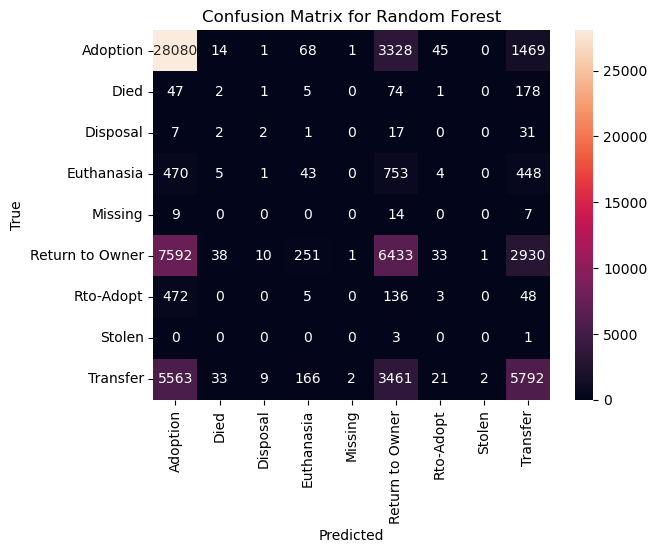

In [107]:
from sklearn.metrics import confusion_matrix

class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Boosting: 
Let's use a GridSearchCV with a 3-fold CV and try 15, 25, and 50 base classifiers of decision stumps. Then wrap the GridSearchCV in a cross_val_predict with 5-fold CV and display the classification report.

In [108]:
from sklearn.ensemble import AdaBoostClassifier
warnings.filterwarnings("ignore")

boost = AdaBoostClassifier()
parameter = {
    'n_estimators': [15, 25, 50]
}
grid = GridSearchCV(boost, parameter, cv=3)
pred = cross_val_predict(grid, features, label, cv=5)
print('Classification Report: \n', classification_report(label, pred))
warnings.resetwarnings()

Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.86      0.71     33006
           1       0.00      0.00      0.00       308
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00      1724
           4       0.00      0.13      0.00        30
           5       0.52      0.17      0.26     17289
           6       0.00      0.00      0.00       664
           7       0.00      0.00      0.00         4
           8       0.59      0.32      0.42     15049

    accuracy                           0.53     68134
   macro avg       0.19      0.17      0.15     68134
weighted avg       0.56      0.53      0.50     68134



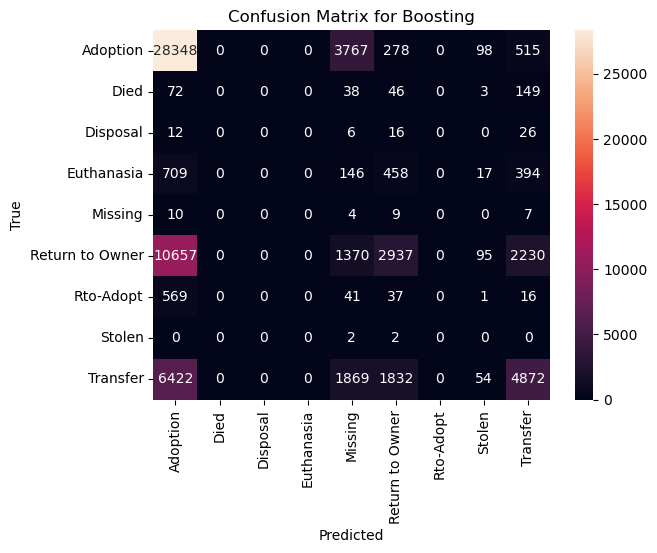

In [109]:
from sklearn.metrics import confusion_matrix

class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Boosting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Model 2. Decision Tree

Next, we will create a Decision Tree. I implemented hyperparameter optimization for a Decision Tree classifier using a grid search strategy to find the identify the most effective combination of hyperparameters—specifically, the maximum depth of the Decision Tree (`max_depth`) and the number of splits in the StratifiedKFold cross-validator (`n_splits`). Further, a cross-validation was implemented to ensure the best split of the dataset.

The script tracks the best hyperparameter values by comparing mean accuracies. The split that yields the best accuracy has max_depth of 10 and N-splits of 40. The best overall accuracy is 0.62.

In [29]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_text
import numpy as np
import warnings
warnings.filterwarnings("ignore")

X = dog_data.drop('Outcome Type', axis=1)
y = dog_data['Outcome Type']

# max_depth and n_splits we want to try
max_depth_values = [5, 10, 15, 20]
n_splits_values = [10, 20, 30, 40]

best_mean_accuracy = 0
best_max_depth = None
best_n_splits = None

# iterate over max_depth and n_splits values
for max_depth in max_depth_values:
    for n_splits in n_splits_values:
        dt_model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=2)
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # perform cross-validation
        cv_scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')
        mean_accuracy = np.mean(cv_scores)

        # update the best parameters if the current combination is better
        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_max_depth = max_depth
            best_n_splits = n_splits

# print the best hyperparameters and mean accuracy
print("Best Max Depth:", best_max_depth)
print("Best N_splits:", best_n_splits)
print("Best Mean Accuracy:", best_mean_accuracy)

Best Max Depth: 10
Best N_splits: 40
Best Mean Accuracy: 0.6206981293712559


### Model 3: K-Nearest Neighbor

The K-nearest neighbor modeling is an algorithm that's simple to understand and implement. It's simplicity and high accuracy potential is why we decided to use it to model our dataset. However, there are various additional considerations we must take into account when using KNN. In cases where a class inbalance exists, KNN is prone to break down. In our case, we have certain class labels that dominate our data. For example, the majority of our outcome instances are adoption, return to owner, and transfer. These outcomes are only three out of nine potential outcomes but make up about 95% of the outcome types in our data. We need to institute a measure to combat against this imbalance. Using weighted voting for our model will prevent the class imbalance from harming our results. In our grid search, weighted and uniform vote will be one of our parameters to see which hyperparameter leads to the better results. This will check for class imbalances worsening our model accuracy. We will also hypertune our parameter K to find a K value that fits our data well and can generalize to new data points too, avoiding overfitting or underfitting. 

Here we're training KNN Model. Grid search will allow us to optimize for our paramaters. We also want to scale our data before training the model since the KNN's algorithm is based on distance and we want to make sure each feature's distances are on the same scale. 



In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

# seperate features & labels
features = dog_data.drop('Outcome Type', axis=1)
labels = dog_data['Outcome Type']

# KNN with 80-20 train/test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
x_test = np.ascontiguousarray(x_test)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_test_scaled = np.ascontiguousarray(x_test_scaled)


#initialize parameter grid to find best parameters
param_grid = {
    'n_neighbors': range(3, 25),
    'weights': ['uniform', 'distance']
}

#create knn classifier 
KNN_classifier = KNeighborsClassifier()

# search for best parameters
grid_search = GridSearchCV(KNN_classifier, param_grid, cv=4, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for KNN model:", best_params)

warnings.resetwarnings()


Best Hyperparameters for KNN model: {'n_neighbors': 23, 'weights': 'uniform'}


Calculate the accuracy for the model

In [32]:
from sklearn.metrics import classification_report

print("Best Cross-Validated Accuracy:", grid_search.best_score_)

# calculate accuracy using best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy for each trial:", accuracy)
avg_test_scores = grid_search.cv_results_['mean_test_score']
print(avg_test_scores)

# get classfification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", report)

Best Cross-Validated Accuracy: 0.6139198708541239
Test Accuracy for each trial: 0.6115635776652726
[0.55963824 0.55591429 0.57508439 0.56679263 0.58524729 0.57411212
 0.59242002 0.58077121 0.59535515 0.58218374 0.60074846 0.58594438
 0.60245451 0.58667816 0.60641694 0.58911799 0.60711403 0.59029205
 0.60922366 0.59126431 0.60748092 0.59119093 0.6090769  0.59262181
 0.60953552 0.59201644 0.61025095 0.59276856 0.61193866 0.59353904
 0.61215879 0.59407103 0.61080129 0.59275022 0.61278251 0.59374083
 0.61311271 0.59456633 0.61371808 0.59506164 0.61391987 0.59474978
 0.61358967 0.59542853]
Classification Report:
                  precision    recall  f1-score   support

       Adoption       0.65      0.90      0.76      6547
           Died       1.00      0.00      0.00        55
       Disposal       1.00      0.00      0.00        10
     Euthanasia       1.00      0.00      0.00       340
        Missing       1.00      0.00      0.00         4
Return to Owner       0.48      0.34     

SVM -> was taking wayy too long to run

In [ ]:
# from sklearn.svm import SVC

# features = dog_data.drop('Outcome Type', axis=1)
# labels = dog_data['Outcome Type']

# # test different c + kernel hyperparameters
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
# }

# x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# svm_model = SVC()
# grid_search = GridSearchCV(svm_model, param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search.fit(x_train, y_train)
# print("Best Parameters:", grid_search.best_params_)
# y_pred = grid_search.predict(x_test)


In [ ]:
# accuracy = accuracy_score(y_test, y_pred)
# print("accuracy of SVM model : ", accuracy)
# print(classification_report(y_test, y_pred))

A potential reason for low accuracy could be the class imbalance that exists within the dataset. We have a lot of data/records for certain classes + those are the classes that tend to have to most data predicted accurately whereas underrepresented classes don't have e